# PyTorch Cart-Pole tutorial
https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [1]:
import gym
import math
import random
import numpy as np
# %matplotlib inline
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.pyplot as plt
plt.ion() # turn on interactive mode
from collections import namedtuple
from itertools import count
from PIL import Image
from IPython import display

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

### Notes on rendering (specific to Jupyter Notebook)
* env.render(mode='rgb_array') only works with pyglet v1.2.4 ($pip install pyglet==1.2.4) and not newer versions

* to prevent render from opening in a new window, open python notebook using xvfb ($xvfb-run -s "-screen 0 1400x900x24" jupyter notebook)

In [2]:
# env = gym.make('CartPole-v0').unwrapped
# observation = env.reset()

# fig = plt.figure('Cart pole')
# img = plt.imshow(env.render(mode='rgb_array'))

# for _ in range(200):
#     x = env.render(mode='rgb_array') # in rgb_array mode this returns a numpy array
    
#     # update the figure to show new state
#     img.set_data(x) # this is a lot faster than calling imshow every time
#     fig.canvas.draw()
    
#     action = env.action_space.sample()
#     observation, reward, done, info = env.step(action)
#     if(done): # it looks like the failure condition is quite a small deviation from vertical (it's 12deg)
#         break

# # alternatively
# fig = plt.figure()
# img = plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
#            interpolation='none')

# for i in range(500):
#     # update the figure to show new state
#     img.set_data(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy())
#     fig.canvas.draw()

#     action = env.action_space.sample()
#     observation, reward, done, info = env.step(action)
#     if(done):
#         break

### Replay memory
Stores transitions. randomly sampling these during training decorrelates them (stabilizes, improves training)

In [3]:
Transition = namedtuple('Transition', ['state', 'action', 'new_state', 'reward'])

class ReplayMemory(object):
    def __init__(self, capacity):
        # circular-buffer-like, with length of list expanding up to capacity, and then overwriting oldest entries
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    def push(self, *args):
        '''Adds a transition to memory'''
        # if memory hasn't stored max number of states, expand size
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        # store transition in memory. if memory is at capacity, overwrite oldest stored transition
        self.memory[self.position] = Transition(*args)
        # increment position in memory queue
        self.position = (self.position + 1) % self.capacity 
        
    def sample(self, batch_size):
        '''Returns batch_size number of randomly selected stored transitions'''
        return random.sample(self.memory, batch_size)
    
    # overload len()
    def __len__(self):
        return len(self.memory)

## DQN algorithm
note: environment is deterministic.

Want to train a policy $\pi(s)$ (mapping from state to action) that maximizes the discounted return $R_t = \Sigma_{t}^{T}\gamma^t r_t$, where $\gamma \in [0,1]$ is the discount factor, and $r_t$ is the reward received at time $t$

Want to find an optimal value function $Q^*(s,a)$ which quantifies the value (expected return) of taking action $a$ from state $s$. It is then easy to find the optimal policy $\pi^*(s) = argmax_aQ^*(s,a)$, i.e. to always choose the action with maximum expected return.

Approximate $Q^*$ using a neural network.

The value function $Q$ obeys the deterministic Bellman equation $Q^{\pi}(s,a) = r + \gamma Q^{\pi}(s',\pi(s))$, i.e. the state-action value is equal to the reward received from taking action $a$ plus the discounted value of reaching the new state $s'$

We want $Q^{\pi}$ to converge to $Q^*$, so the loss is defined using the temporal difference error $\delta = Q^{\pi}(s,a) - (r + \gamma max_a Q^{\pi}(s',a))$

Use Huber loss over batch $B$ sampled from replay memory: $L = \frac{1}{|B|}\Sigma L(\delta)$ where $L{\delta} = \frac{1}{2}\delta^2$ if $|\delta| < 1$, $|\delta| - \frac{1}{2}$ otherwise

### Q-network
Train CNN that takes difference between current and previous frames (note: what about acceleration?) as inputs, and outputs two scalars: $Q(s,right)$ and $Q(s,left)$

In [4]:
# network has three conv/batchnorm/relu layers, followed by a fully-connected output layer
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        
        self.layer1 = nn.Sequential(
                        nn.Conv2d(3, 16, kernel_size=5, stride=2),
                        nn.MaxPool2d(2),
                        nn.BatchNorm2d(16))
        self.layer2 = nn.Sequential(
                        nn.Conv2d(16, 32, kernel_size=5, stride=2),
                        nn.MaxPool2d(2),
                        nn.BatchNorm2d(32))
        self.layer3 = nn.Sequential(
                        nn.Conv2d(32, 32, kernel_size=5, stride=2),
                        nn.MaxPool2d(2),
                        nn.BatchNorm2d(32))
        self.fc_out = nn.Linear(128, 2) # how do you come up with # of input features?
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = x.view(x.size(0), -1) # reshape into single vector
        return self.fc_out(x)

In [5]:
# screen capture
screen_width = 600 # hardcoded in cartpole.py render()

def get_cart_location():
    world_width = env.x_threshold * 2 # x_threshold is 2.4, which defines termination state
    scale = screen_width/world_width
    # return middle of the cart (converts simulation coordinates to display coordinates and shifts origin)
    return int(env.state[0] * scale + screen_width / 2.0) # env.state[0] is position (origin is middle of screen)

def get_screen():
    '''Returns a torch tensor of a square slice of pixels surrounding the cart location'''
    screen = env.render(mode='rgb_array')
    screen = screen.transpose(2,0,1) # switch from (height x width x nChannel) to (nChannel, height, width)
    screen = screen[:,160:320,:] # remove top and bottom of frame
    # remove edges around cart
    x_cart = get_cart_location()
    # vertical segment width, centered at cart
    view_width = 330
    x_min = max(x_cart-view_width//2.0, 0)
    x_max = min(x_cart+view_width//2.0, screen_width)
    screen = screen[:,:,int(x_min):int(x_max)]
    
    # normalize pixel values and ensure continuous memory
    screen = np.ascontiguousarray(screen, dtype=np.float32)/255
    # adds in batch dimension and returns
    # coverts to torch tensor and adds batch dimension
    return torch.from_numpy(np.expand_dims(screen, 0))

## Training helper functions and parameters

In [6]:
# instantiate policy network to train and replay memory
policy_net = DQN()

# wut?
target_net = DQN()
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

memory = ReplayMemory(capacity=1000)

epsilon = 0.9
target_update = 10

optimizer = optim.RMSprop(policy_net.parameters())

# used trained DQN to choose action based on state
# to start with, use fixed epsilon (for epsilon-greedy policy)
def select_action(state):
    '''Selects an action (left=0, right=1) based on DQN with state as input'''
    if(np.random.uniform(0,1) < 0.9):
        with torch.no_grad():
            # predict action values
            actions = policy_net(state)
        return actions.max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(2)]], dtype=torch.long)

## Training

In [7]:
batch_size = 100
gamma = 0.999

def optimize_step():
    # sample randomly from stored (state, action, reward, new_state) sets
    # don't start optimizing until a minimum number of transitions have been taken
    if len(memory) < batch_size:
        return
    transitions = memory.sample(batch_size) # returns batch_size tuples (state, action, new_state, reward)
    batch = Transition(*zip(*transitions)) # reshuffles to 4 tuples of batch_size elements
    
    # create masks of final and non-final states
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, 
                                            batch.new_state)), dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.new_state
                                                if s is not None])
    
    # extract elements of batch
    # cat takes tuple of tensors
    state_batch = torch.cat(batch.state)
    action_batch = torch.tensor(batch.action, dtype=torch.long) # complains that it got a tuple when expecting a Variable
    reward_batch = torch.tensor(batch.reward, dtype=torch.long)
#     action_batch = torch.cat(batch.action)
#     reward_batch = torch.cat(batch.reward)
    
    # calculate Q(s,a), the state-action value function which is being approximated by the DQN
    # invalid argument 4: Index tensor must have same dimensions as input tensor
    tmp = policy_net(state_batch)
#     print(tmp.size()) #[100,2] --> makes sense, it's the predicted values of the two actions for each transition
#     print(action_batch.size()) #[100]
    # want to select the action value (column of tmp) for each batch member corresponding to action taken
#     state_action_values = torch.gather(tmp, 0, action_batch) 
    state_action_values = torch.tensor([tmp[i,action_batch[i]] for i in range(len(action_batch))],requires_grad=True)
    
    # calculate V(s'), the value of all subsequent states
    next_state_values = torch.zeros(batch_size)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * gamma) + reward_batch.type(dtype=torch.float)

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)
    
    # backpropagate
    optimizer.zero_grad()
    loss.backward()
#     for param in policy_net.parameters():
#         param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [8]:
# init environment and state
env = gym.make('CartPole-v0').unwrapped

n_episodes = 100
n_steps = 0
for i_episode in range(n_episodes):
    env.reset()
    current_screen = get_screen()
    state = current_screen - current_screen

    # loop until the episode finishes
    init_loop = True
    done = False
    while not done:
        # select and perform an action
        # on first loop, randomly choose action, since state is undefined (no previous state)
        if(init_loop):
            action = np.random.choice([0,1])
            init_loop = False
        else:
            # perform forward pass through DQN
            action = select_action(state)
        
        # update environment based on action taken
        _, reward, done, _ = env.step(action.item())

        # observe resulting state (if episode hasn't terminated)
        # state is difference between previous and current screen image
        next_state = None
        if(not done):
            prev_screen = current_screen
            current_screen = get_screen()
            next_state = current_screen - prev_screen

        # store the new transition to memory
        memory.push(state, action, next_state, reward)

        # update the state
        state = next_state

        # optimize network
        optimize_step()
        
        n_steps += 1
    
    print('episode %i of %i : %i steps' %(i_episode+1, n_episodes, n_steps))
    n_steps = 0

print('Training complete.')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
episode 1 of 100 : 14 steps
episode 2 of 100 : 22 steps
episode 3 of 100 : 21 steps
episode 4 of 100 : 54 steps
episode 5 of 100 : 16 steps
episode 6 of 100 : 32 steps
episode 7 of 100 : 17 steps
episode 8 of 100 : 16 steps
episode 9 of 100 : 90 steps
episode 10 of 100 : 17 steps
episode 11 of 100 : 47 steps
episode 12 of 100 : 13 steps
episode 13 of 100 : 17 steps
episode 14 of 100 : 13 steps
episode 15 of 100 : 11 steps
episode 16 of 100 : 16 steps
episode 17 of 100 : 31 steps
episode 18 of 100 : 17 steps
episode 19 of 100 : 12 steps
episode 20 of 100 : 11 steps
episode 21 of 100 : 12 steps
episode 22 of 100 : 30 steps
episode 23 of 100 : 34 steps
episode 24 of 100 : 51 steps
episode 25 of 100 : 11 steps
episode 26 of 100 : 24 steps
episode 27 of 100 : 22 steps
episode 28 of 100 : 17 steps
episode 29 of 100 : 15 steps
episode 30 of 100 : 20 steps
episode 31 of 100 : 24 steps
episode 32 

## Evaluate success of training

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


<IPython.core.display.Javascript object>


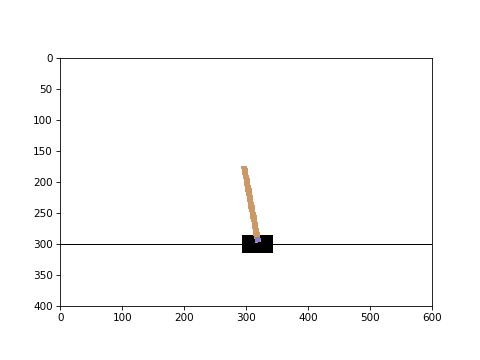

True


In [16]:
env = gym.make('CartPole-v0').unwrapped
env.reset()

fig = plt.figure()
img = plt.imshow(env.render(mode='rgb_array'))

current_screen = get_screen()
state = current_screen - current_screen

inir_loop = True
for _ in range(200):
    x = env.render(mode='rgb_array') # in rgb_array mode this returns a numpy array
    
    if(init_loop):
            action = np.random.choice([0,1])
            init_loop = False
    else:
            # perform forward pass through DQN
            action = select_action(state)
    
    # update the figure to show new state
    img.set_data(x) # this is a lot faster than calling imshow every time
    fig.canvas.draw()
    
    _, reward, done, _ = env.step(action.item())
    
    prev_screen = current_screen
    current_screen = get_screen()
    state = current_screen - prev_screen
    
    
    if(done): # it looks like the failure condition is quite a small deviation from vertical (it's 12deg)
        print(done)
        break